In [6]:
import os
import copy
import time
import math
import shutil
import argparse
import warnings

import numpy as np
import pandas as pd
from cv2 import cv2

import matplotlib.pyplot as plt

from config.Config import Config
from exploration.explorer import Explorer
from agent.agent_handler import AgentHandler
from grid_world_generator.grid_world import GridWorld
from region_assignment.k_mean_clustring import KMeanClustring
from utils.util_functions import get_cost_matrix, stateCoordsToName
from utils.graph import get_closest_vertex_coords_on_graph_from_pos
from region_assignment.hungarian_region_assignment import HungarianRegionAssignment
from occupancy_grid_generator.occupancy_grid_generator import OccupancyGridGenerator

In [2]:
warnings.filterwarnings("ignore")

verbose = Config.VERBOSE
grid_len = Config.GRID_LEN
edge_cost = Config.EDGE_COST
grid_width = Config.GRID_WIDTH
show_results = Config.SHOW_RESULTS
sensor_range = Config.SENSOR_RANGE
no_of_agents = Config.NO_OF_AGENTS
complexity_level = Config.COMPLEXITY_LEVEL
path_to_save_results = Config.PATH_TO_SAVE_RESULTS

if os.path.isdir(path_to_save_results):
    if verbose:
        print("Previous results exists, Clearing...")
    shutil.rmtree(path_to_save_results)

os.makedirs(path_to_save_results, exist_ok=True)

In [3]:
def occupancy_grid_generator():

    if verbose:
        print("-----------------------------------------------------------")
        print("----------------OCCUPANCY-GRID-GENERATOR-------------------")
        print("-----------------------------------------------------------\n")
    
    occupancy_grid = OccupancyGridGenerator()
    occupancy_grid.generate_occupancy_grid()

    if show_results:
        occupancy_grid.show_occupancy_grid_without_obs()
        occupancy_grid.show_occupancy_grid_with_obs()
    
    temp_occupancy_grid_without_obs = occupancy_grid.get_occupancy_grid_without_obs()
    temp_occupancy_grid_with_obs = occupancy_grid.get_occupancy_grid_with_obs()

    temp_file_name = "Grid_with_Obstacles.png"
    cv2.imwrite(os.path.join(path_to_save_results,temp_file_name), temp_occupancy_grid_with_obs)
    temp_file_name = "Grid_without_Obstacles.png"
    cv2.imwrite(os.path.join(path_to_save_results,temp_file_name), temp_occupancy_grid_without_obs)
    
    return temp_occupancy_grid_without_obs, temp_occupancy_grid_with_obs


def grid_world(temp_occupancy_grid_without_obs):

    if verbose:
        print("-----------------------------------------------------------")
        print("-------------------GRID-WORLD-GENERATOR--------------------")
        print("-----------------------------------------------------------\n")
        print("Edge Cost:", edge_cost, ", Sensor Range:", sensor_range, "\n")
        # print(", Grid Node Width:", X_DIM, ", Grid Node Height:", Y_DIM)
    
    X_DIM = int(grid_width/edge_cost)
    Y_DIM = int(grid_len/edge_cost)

    graph_list = []

    for i in range(no_of_agents):

        graph_list.append(GridWorld(X_DIM, Y_DIM, temp_occupancy_grid_without_obs))

        graph_list[i].run()
        # temp_graph = copy.copy(graph.get_graph())

    if show_results:
        graph_list[-1].show_nodes_on_occupancy_grid()
        graph_list[-1].show_nodes_and_edges_with_obs_on_occupancy_grid()
        graph_list[-1].show_nodes_and_all_traversable_edges()

    temp_grid_with_nodes = graph_list[-1].get_occupancy_grid_with_nodes()
    temp_grid_with_nodes_and_edges_with_obs = graph_list[-1].get_occupancy_grid_with_nodes_and_edges_with_obs()
    temp_grid_with_nodes_and_all_traversable_edges = graph_list[-1].get_occupancy_grid_with_nodes_and_all_traversable_edges()

    temp_file_name = "Grid_with_nodes.png"
    cv2.imwrite(os.path.join(path_to_save_results,temp_file_name), temp_grid_with_nodes)
    temp_file_name = "Grid_with_red_lines_bw_non_traversable_nodes.png"
    cv2.imwrite(os.path.join(path_to_save_results,temp_file_name), temp_grid_with_nodes_and_edges_with_obs)
    temp_file_name = "Grid_with_blue_lines_bw_traversable_nodes.png"
    cv2.imwrite(os.path.join(path_to_save_results,temp_file_name), temp_grid_with_nodes_and_all_traversable_edges)

    temp_graph_list = copy.copy(graph_list)
    
    return temp_graph_list, temp_grid_with_nodes


def k_mean_clustring(temp_occupancy_grid_without_obs):
    
    if verbose:
        print("-----------------------------------------------------------")
        print("---------------------K-MEAN-CLUSTRING----------------------")
        print("-----------------------------------------------------------\n")

    regions = KMeanClustring(temp_occupancy_grid_without_obs)

    regions.find_regions()

    # temp_regions_xy_points = regions.get_regions_xy_points()
    temp_region_centroids = regions.get_centroids()
    temp_color_map = regions.get_color_map()
    temp_grid_with_regions = copy.copy(regions.get_grid_with_regions())
    
    if show_results:
        regions.show_regions_with_centroids()
    # regions.show_regions()

    temp_file_name = "Grid_with_region_and_centroids.png"
    cv2.imwrite(os.path.join(path_to_save_results,temp_file_name), temp_grid_with_regions)

    # ind = 0
    # for el in temp_regions_xy_points:
    #     print("Region", ind, "indices:", el)
    #     ind += 1

    if verbose:
        print("Region centroids:\n\n", temp_region_centroids, "\n")
        print("Region color map:\n\n", temp_color_map, "\n")
    
    return temp_region_centroids, temp_color_map, temp_grid_with_regions


def region_assignment(temp_region_centroids, agenthandler, temp_grid_with_regions, temp_graph_list, temp_grid_with_nodes, temp_color_map):

    if verbose:
        print("-----------------------------------------------------------")
        print("---------------HUNGARIAN-REGION ASSIGNMENT-----------------")
        print("-----------------------------------------------------------\n")

    color_map = [[]] * no_of_agents
    goal_pos = [''] * no_of_agents

    region_centroids = copy.copy(temp_region_centroids)

    cost_matrix = get_cost_matrix(no_of_agents, agenthandler, region_centroids)

    hungaian_region_assignment = HungarianRegionAssignment(cost_matrix, \
        temp_grid_with_regions, agenthandler, temp_region_centroids)

    hungaian_region_assignment.find_regions()
    temp_regions_rows, temp_regions_cols = hungaian_region_assignment.get_regions()

    hungaian_region_assignment.place_agents_on_grid_with_info_of_assigned_region()

    ind = 0
    
    for el in temp_regions_cols:
        temp_x, temp_y = temp_region_centroids[el]
        color_map[ind] = temp_color_map[el]
        temp_goal_pos = get_closest_vertex_coords_on_graph_from_pos(\
                            temp_graph_list[ind].get_graph(), temp_x, temp_y, edge_cost)
        # print(temp_goal_pos)
        goal_pos[ind] = stateCoordsToName(temp_goal_pos[1], temp_goal_pos[0], edge_cost)

        ind += 1
        
    if verbose:
        print("\nNew Color Map Order:", color_map, "\n")

    if show_results:
        hungaian_region_assignment.show_assigned_regions()

    grid_with_regions_and_agents = hungaian_region_assignment.get_grid_with_regions_and_agents()
    grid_with_regions = hungaian_region_assignment.get_grid_with_regions()

    temp_file_name = "Grid_with_agents_and_respective_region.png"
    cv2.imwrite(os.path.join(path_to_save_results,temp_file_name), grid_with_regions_and_agents)

    if verbose:
        print("Region centroids:\n")
        ind = 1
        for el in region_centroids:
            print("\tRegion:", ind, ", x:", el[0], ", y:", el[1])
            ind += 1

        print("\nAgent Positions:\n")

        for i in range(no_of_agents):
            temp_agent_pos = agenthandler.get_pos_of_agent(i)
            print("\tAgent:", i+1, ", x:", temp_agent_pos['x'], ", y:", temp_agent_pos['y'])

        print("\nCost Matrix:\n\n", np.array(cost_matrix, dtype=np.int), "\n")

        ind = 1
        for el in temp_regions_cols:
            print("Region Assigned to Agent: {} is Region {}".format(ind, el))
            ind += 1

        print("\nTotal cost:", int(hungaian_region_assignment.get_total_cost()), "\n")
    
    return goal_pos, color_map, temp_regions_cols, grid_with_regions


def time_stats(start_time, mission_complete_status):
    
    end_time = time.time()
    
    if mission_complete_status:
        temp_complete_path = os.path.join(os.getcwd(), "results")
        os.makedirs(temp_complete_path, exist_ok=True)

        exploration_data = pd.read_csv(os.path.join(temp_complete_path, complexity_level + '.csv'), delimiter=',')

        if exploration_data['no_of_tries'][int(no_of_agents-1)] > 0:
            temp_time = exploration_data['exploration_time'][int(no_of_agents-1)] * exploration_data['no_of_tries'][int(no_of_agents-1)]
            new_time = (temp_time + (end_time-start_time)) / (exploration_data['no_of_tries'][int(no_of_agents-1)] + 1)
            if verbose:
                print("No of tries > 0")
                print("Old time:", exploration_data['exploration_time'][int(no_of_agents-1)])
                print("New time:", new_time)
            exploration_data['exploration_time'][int(no_of_agents-1)] = new_time
        else:
            if verbose:
                print("No of tries = 0")
                print("Old time:", exploration_data['exploration_time'][int(no_of_agents-1)])
                print("New time:", float(end_time-start_time))
            exploration_data['exploration_time'][int(no_of_agents-1)] = float(end_time-start_time)
        
        if verbose: print("Old number of tries:", exploration_data['no_of_tries'][int(no_of_agents-1)])
        exploration_data['no_of_tries'][int(no_of_agents-1)] += 1
        if verbose: print("New number of tries:", exploration_data['no_of_tries'][int(no_of_agents-1)])

        exploration_data.to_csv(os.path.join(temp_complete_path, complexity_level + '.csv'), index=None)
        
        temp_no_of_agents_list = []
        temp_time_list = []

        for i in range(len(exploration_data)):
            if exploration_data.iloc[i]['exploration_time'] != np.nan or exploration_data.iloc[i]['exploration_time'] != 0 or exploration_data.iloc[i]['exploration_time'] != np.inf:
                temp_no_of_agents_list.append(exploration_data.iloc[i]['no_of_agents'])
                temp_time_list.append(exploration_data.iloc[i]['exploration_time'])

        plt.figure()
        plt.plot(temp_no_of_agents_list, temp_time_list, 'bo')
        plt.plot(temp_no_of_agents_list, temp_time_list, 'b-')
        plt.savefig(os.path.join(path_to_save_results, 'agent_vs_time_plot.png'))
        plt.xlabel('Number of Agents')
        plt.ylabel('Time(sec)')
        
        if show_results:
            plt.show()
        
        if verbose:
            print("Time to complete Multi Agent Exploration Mission: {} seconds.".format(end_time-start_time))

In [4]:
def main():


    start_time = time.time()

    if verbose:
        print("-----------------------------------------------------------")
        print("-----------------MULTI-AGENT-EXPLORATION-------------------")
        print("-----------------------------------------------------------\n")
    
    # ------------------ OCCUPANCY GRID GENERATOR ------------------ #
    
    temp_occupancy_grid_without_obs, temp_occupancy_grid_with_obs = occupancy_grid_generator()
    
    # -------------------------- GRID WORLD ------------------------ #
    
    temp_graph_list, temp_grid_with_nodes = grid_world(temp_occupancy_grid_without_obs)

    # ---------------------- K-MEAN-CLUSTRING ---------------------- #
    
    temp_region_centroids, temp_color_map, temp_grid_with_regions = k_mean_clustring(\
                                                                        temp_occupancy_grid_without_obs)
    
    # ------------------------ AGENT HANDLER ----------------------- #
    
    agenthandler = AgentHandler(temp_graph_list)
    
    # --------------------- REGION ASSIGNMENT ---------------------- #
    
    goal_pos, color_map_new, regions_cols, grid_with_regions = region_assignment(temp_region_centroids, agenthandler, \
        temp_grid_with_regions, temp_graph_list, temp_grid_with_nodes, temp_color_map)
    
    # ------------------------- Explorer --------------------------- #
    
    explorer = Explorer(global_grid=temp_occupancy_grid_with_obs, known_grid=temp_occupancy_grid_without_obs, \
                        assigned_region_node_names=goal_pos, graph_list=temp_graph_list, \
                        agenthandler=agenthandler, color_map=color_map_new, regions_cols=regions_cols, \
                        grid_with_regions=temp_grid_with_regions, grid_with_regions_info=grid_with_regions)
    
    mission_complete_status = explorer.run()
    
    # -------------------------Time Stats--------------------------- #

    time_stats(start_time, mission_complete_status)
    
    # -------------------------------------------------------------- #

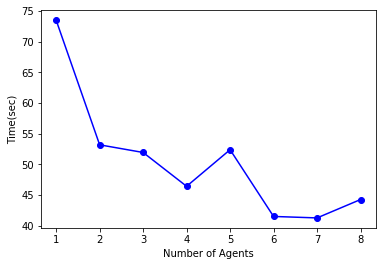

In [5]:
main()